In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import pickle

import fiona
from itertools import chain

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint
from descartes import PolygonPatch

import matplotlib.colors as mpl_colors
from random import randint
import time

from geopy.distance import vincenty

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

In [7]:
img_width_inches = 7.22 * 3
img_height_inches = 5.25 * 3

base, offset = 80, 150
route_idx_bay = 115
route_idx_split = 93

with open('./data_routes_pickle/cell_id_lac_info', 'rb') as f:
    station_dict = pickle.load(f)
    
with open('./data_routes_pickle/routes_user_id', 'rb') as f:
    routes_user_id = pickle.load(f)

with open('./data_routes_pickle/routes_coord', 'rb') as f:
    routes_coord = pickle.load(f)

with open('./data_routes_pickle/routes_cell_id', 'rb') as f:
    routes_station = pickle.load(f)

In [8]:
len(routes_station)

6489

In [10]:
shp = fiona.open('data_maps_input/spb.shp')
bds = shp.bounds
shp.close()

ll = bds[0], bds[1]
ur = bds[2], bds[3]
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
zoom_out_frac = 0.0

m = Basemap(
    projection='tmerc',
    lon_0=30.5,
    lat_0=60.,
    ellps='WGS84',
    llcrnrlon=coords[0] - zoom_out_frac * w,
    llcrnrlat=coords[1] - zoom_out_frac * h,
    urcrnrlon=coords[2] + zoom_out_frac * w,
    urcrnrlat=coords[3] + zoom_out_frac * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

In [ ]:
m.readshapefile(
    'data_maps_input/spb',
    'city_polygons',
    drawbounds=False)

df_map = pd.DataFrame({
    'poly': [Polygon(polygon_coords) for polygon_coords in m.city_polygons]})

df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=0.25, alpha=.9,
    zorder=2))

In [11]:
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in 
     [(station_dict[i][0], station_dict[i][1]) for i in station_dict]])

station_points = MultiPoint(list(map_points.values))

In [ ]:
dists = [0.0] * len(routes_coord)
for i in range(len(routes_coord)):
    path = routes_coord[i]
    for j in range(len(path) - 1):
        point1, point2 = path[j], path[j + 1]
        dists[i] += vincenty(point1, point2).miles

In [ ]:
global_dist_idxs = [i for i, dist in enumerate(dists) if dist < 7]
routes_station_filtered_global_dist = [routes_station[i] for i in global_dist_idxs]
print(len(routes_station))
print(len(routes_station_filtered_global_dist))

Plotting done


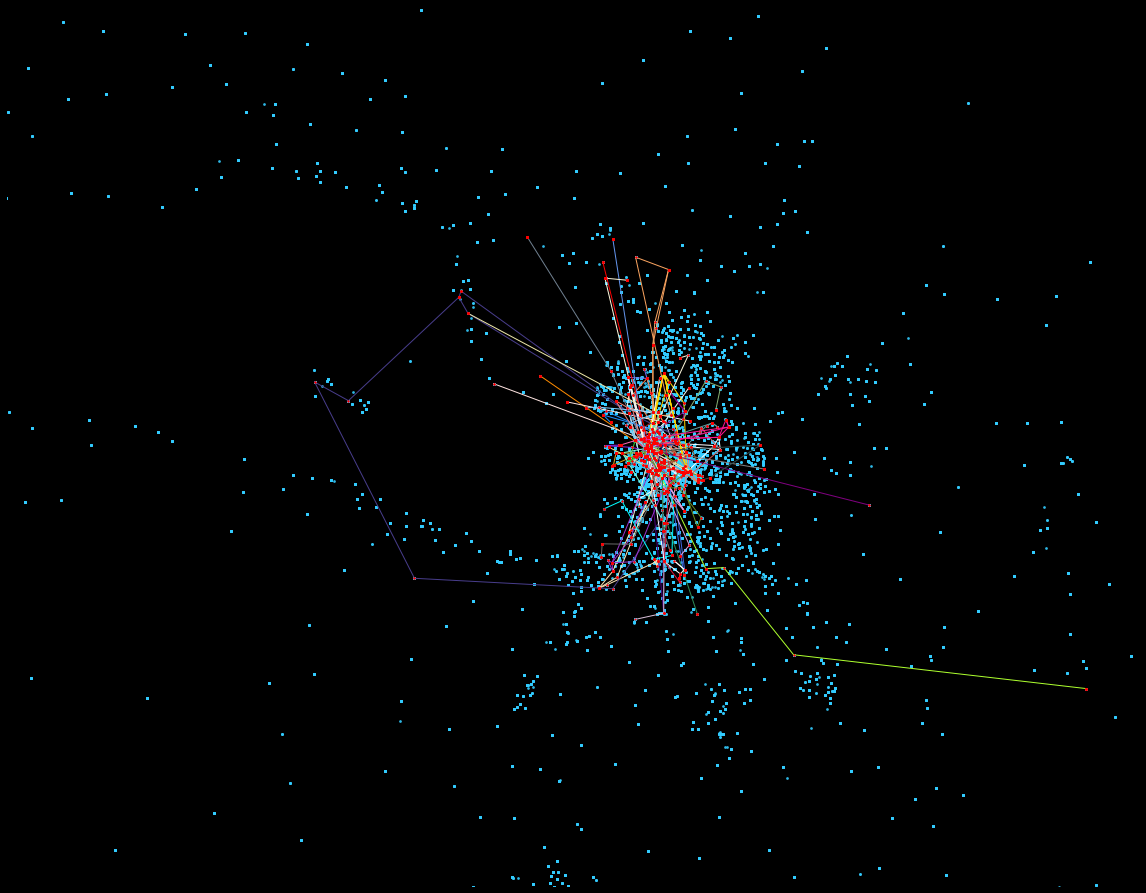

In [12]:
plt.clf()
fig = plt.figure(facecolor='black')
ax = fig.add_subplot(111, frame_on=False)

m.scatter(
    [geom.x for geom in list(station_points)],
    [geom.y for geom in list(station_points)],
    30, marker='.', lw=.0,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True, zorder=3)

# colors = ['red', 'white', 'blue', 'yellow', 'green']
colors = list(mpl_colors.cnames.keys())
cur_color = colors[0]

paths = routes_station[80:150]
# paths = routes_coord

for j in range(len(paths)):
    path = paths[j]
    pathcoords = [(station_dict[x][0], station_dict[x][1]) for x in path]
#     pathcoords = path
    
    cur_color = colors[j % len(colors)]
    
    for i in range(len(pathcoords) - 1):
        point1, point2 = pathcoords[i], pathcoords[i + 1]
        
        map_point1 = Point(m(point1[0], point1[1]))
        map_point2 = Point(m(point2[0], point2[1]))
        
        xs = [map_point1.x, map_point2.x]
        ys = [map_point1.y, map_point2.y]
        
        m.scatter(
            xs, ys,
            20, marker='.', lw=.0,
            facecolor='red', edgecolor='w',
            alpha=0.9, antialiased=True, zorder=5)
        
        plt.plot(xs, ys, linestyle='-', color=cur_color, zorder=4)

print('Plotting done')

# ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

fig.set_size_inches(img_width_inches, img_height_inches)

plt.savefig(
    "data_maps_output/routes {}.png".format(int(time.time())),
    dpi=200, alpha=True, facecolor=fig.get_facecolor())

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(coord_list[:100])
idxs = kmeans.predict(coord_list[:100])
idxs

In [ ]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in list(station_points)],
    [geom.y for geom in list(station_points)],
    5, marker='.', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True, zorder=3)

# colors = ['red', 'black', 'blue', 'yellow', 'green']
colors = list(mpl_colors.cnames.keys())
base = 48
# TODO WTF Why -2
all_coords = list(coord_list)[base:base + 50]
for j in range(len(all_coords)):
    pathcoords = all_coords[j]
    for i in range(0, len(pathcoords) - 4, 2):
        point1, point2 = [pathcoords[i], pathcoords[i + 1]], [pathcoords[i + 2], pathcoords[i + 3]]
        map_point1 = Point(m(point1[0], point1[1]))
        map_point2 = Point(m(point2[0], point2[1]))
        xs = [map_point1.x, map_point2.x]
        ys = [map_point1.y, map_point2.y]
        plt.plot(xs, ys, linestyle='-', color=colors[(20 * idxs[base + j]) % len(colors)]) # dirty hack

print('Plotting done')

# ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

fig.set_size_inches(img_width_inches, img_height_inches)
plt.savefig("data_maps_output/routes {}.png".format(int(time.time())), dpi=200, alpha=True)

In [ ]:
idx_set = set(idxs)
idx_set

In [ ]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# colors = ['red', 'black', 'blue', 'yellow', 'green']
colors = list(mpl_colors.cnames.keys())

dev = m.scatter(
    [geom.x for geom in list(station_points)],
    [geom.y for geom in list(station_points)],
    5, marker='.', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True, zorder=3)

for j, pathcoords in enumerate(kmeans.cluster_centers_):
#     print(pathcoords)
    for i in range(0, len(pathcoords) - 4, 2):
        point1, point2 = [pathcoords[i], pathcoords[i + 1]], [pathcoords[i + 2], pathcoords[i + 3]]
        map_point1 = Point(m(point1[0], point1[1]))
        map_point2 = Point(m(point2[0], point2[1]))
        xs = [map_point1.x, map_point2.x]
        ys = [map_point1.y, map_point2.y]
        plt.plot(xs, ys, linestyle='-', color=colors[(17 * idxs[base + j]) % len(colors)])

print('Plotting done')

# plot boroughs by adding the PatchCollection to the axes instance
# ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

fig.set_size_inches(img_width_inches, img_height_inches)
plt.savefig("data_maps_output/routes {}.png".format(int(time.time())), dpi=200, alpha=True)